I am going to build the architecture. Then I am going to make sure it can run. Then I am going to display the results in another file because I feel like this will take very long to run otherwise.

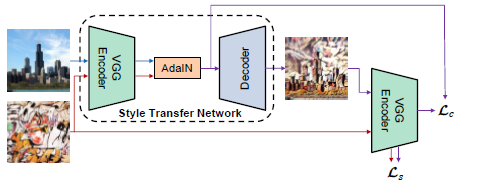

Above is the model. We are going to be training only the Decoder part I believe. I think in test time we will use the VGG Encoder(on the left) like in train but we are going to drop the right Loss network

In [ ]:
import tensorflow as tf 
from tensorflow.keras.applications.vgg19 import VGG19

First we input our Base Model, we are going to use this Base Model to then get the two vgg encoders. (We will build the decoder ourselves)

In [ ]:
base_model = VGG19(weights = 'imagenet', include_top=False)
base_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In the paper it seems like they go up to block4_conv1 for their feature extractions, so I am going to assume we just use this output for both the image and the style to align. 

Another note: The paper wants to do channel wise mean and variance extraction to perform the AdaIn Layer. So my first instinct is that I should vectorize the spatial dimension of the block4_conv1 output for both the style and content. Then row by row exchange the mean and variance of the content feature channel with the style feature channel as each row will correspond to one channel (since we have vectorized the spatial extent of the output)

In [ ]:
#So lets grab the intermediate layer that the paper uses
vgg_encoder1 = tf.keras.Model(inputs = base_model.inputs, outputs = base_model.get_layer('block4_conv1').output)

Not sure if I missed what layer the authors specified they are going to do content extraction from. But I am going to use block4 conv 4

In [ ]:
#This second encoder will act as our loss network. Much like in my texture synthesis notebook. However we are going to do a trick here. Assume we have n conv outputs in this encoder, I am going to use the first n-1 for the style
#loss, and then the nth one for the content loss. As we know from the papers we have read that content tends to be built over time and as we go higher in the network we will have a more accurate to content feature representation
#and that the lower layers will encoder more of the lower level aspects that we use for the style.
convoutputs = ['block1_conv1', 'block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv4'] #'block4_conv4' will be the only layer that we use for content loss.
Loss_Network = tf.keras.Model(inputs = base_model.inputs, outputs = [base_model.get_layer(name).output for name in convoutputs]) #Note the loss network is also just a vgg 19 encoder.

In [ ]:
#Lets look at the shape of the output from the first encoder, so that we know how to decode it after we put it through the AdaIN layer.
dummynoise = tf.random.normal(shape=(1,224,224,3))
output = vgg_encoder1.predict(dummynoise)
print(output.shape) #Ok so we are working with a 1, 28, 28, 512 so after we transpose and reshape we will have a 512x784 where each row is a channels feature representation. In the decoder we will reshape to 28,28,512 and then pass
#it through the network.

(1, 28, 28, 512)


In [ ]:
#Lets check the transpose shape to make sure we are on the right track mentally 
print(tf.transpose(output).shape) #Perfect!

(512, 28, 28, 1)


In [ ]:
#We can make the decoder relatively simple but first lets make the AdaIn Layer (Not really a layer since it has no learnable parameters rather just an operation)
import numpy as np 
def AdaIN(contentfeatures, stylefeatures):
  contentfeatures = tf.transpose(contentfeatures)
  stylefeatures = tf.transpose(stylefeatures)
  contentfeatures = np.array(tf.reshape(contentfeatures, (contentfeatures.shape[0], contentfeatures.shape[1]*contentfeatures.shape[2])))
  stylefeatures = np.array(tf.reshape(stylefeatures, (stylefeatures.shape[0], stylefeatures.shape[1]*stylefeatures.shape[2])))
  for i in range(len(contentfeatures)):
    contentmean = np.mean(contentfeatures[i])
    contentvariance = np.var(contentfeatures[i])
    contentfeat = (contentfeatures[i]-contentmean)/(contentvariance)
    stylevariance = np.var(stylefeatures[i])
    stylemean = np.mean(stylefeatures[i])
    contentfeatures[i] = (contentfeat*stylevariance) + stylemean 
  contentfeatures = tf.convert_to_tensor(contentfeatures, dtype=tf.float32)
  assert contentfeatures.shape == (512, 784)
  contentfeatures = tf.transpose(contentfeatures) #From 512x784 -> 784x512
  contentfeatures = tf.reshape(contentfeatures, (1,28,28,512))
  return contentfeatures 

## Padding==Same:
H = H1 * stride

# Padding==Valid
H = (H1-1) * stride + HF

For Convolution Transpose output dimensionality. Remember that we want a 224x224x3 output at the end(reshaped to 1x224x224x3 for Loss network compatability).
where, H = output size, H1 = input size, HF = height of filter

In [ ]:
def Decoder():
  model = tf.keras.Sequential([])
  model.add(tf.keras.Input(shape=(28,28,512)))
  model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(1,1), strides = 2, padding = 'same')) #56x56x256 
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=(2,2), strides = 2, padding='same')) #112x112x128
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides = 1, padding = 'same')) # 112x112x32 
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=(1,1), strides = 2, padding = 'same', activation = 'tanh'))
  assert model.output_shape==(None, 224, 224, 3)
  return model 

In [ ]:
instance1 = Decoder()
instance1.summary() #Perfec so it looks like we are getting what we want eh! This Decoder instance is the only instance we are going to be training, we will not be training first encoder. or loss network.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 56, 56, 256)      131328    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 56, 56, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 112, 112, 128)    131200    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 128)     0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 112, 112, 32)     36896     
 ranspose)                                                       
                                                        

In the paper they use AdaInOut for the content loss.
However AdaInOut dimensionality is 1x28x28x512, we need to check the Decoders Dimensionality at block4_conv4 to see if it matches AdaInOut. If it does match then we are solid! Else we are going to have to make some changes :(. We can check with simply instantiating a noise input and seeing the output.

In [ ]:
noise = tf.random.normal(shape=(1,224,224,3))
predictions = Loss_Network.predict(noise)
print(predictions[-1].shape) 

(1, 28, 28, 512)


Oops we got lucky :)

In [ ]:
def Loss_Func(DecoderOutput, AdaInOut, styleinput, alpha):
  DecoderOutput = tf.expand_dims(DecoderOutput,axis=0) #Making this the right size for the loss function. (1, 224, 224, 3)
  #So now we need to compute the styleinputs lower level features (In the paper they authors state they dont use gram matrix but similar results achieved via gram matrix so I am going to use that.)
  assert AdaInOut.shape == (1, 28, 28, 512)
  DecoderFeatures = Loss_Network.predict(DecoderOutput)
  StyleFeatures = Loss_Network.predict(styleinput)
  LossContent = tf.constant(0.0)
  LossStyle = tf.constant(0.0)
  for j in range(len(StyleFeatures)-1):
    StyleInstance = StyleFeatures[j]
    StyleInstance = tf.transpose(StyleInstance)
    StyleInstance = tf.reshape(StyleInstance, (StyleInstance.shape[0], StyleInstance.shape[1]*StyleInstance.shape[2])) #Vectorizing
    StyleGram = tf.linalg.matmul(StyleInstance, StyleInstance, transpose_b=True)
    DecoderInstance = DecoderFeatures[j]
    DecoderInstance = tf.transpose(DecoderInstance)
    DecoderInstance = tf.reshape(DecoderInstance, (DecoderInstance.shape[0], DecoderInstance.shape[1]*DecoderInstance.shape[2])) #Vectorizing
    DecoderGram = tf.linalg.matmul(DecoderInstance, DecoderInstance, transpose_b=True)
    stylenormalizer = 4*tf.square(DecoderGram.shape[0])*tf.square(DecoderGram.shape[1])
    LossStyle += tf.square(tf.subtract(StyleGram, DecoderGram))/(stylenormalizer)
  DecoderInstanceContent = DecoderFeatures[-1]
  DecoderInstanceContent = tf.transpose(DecoderInstanceContent)
  DecoderInstanceContent = tf.reshape(DecoderInstanceContent, (DecoderInstanceContent.shape[0], DecoderInstanceContent.shape[1]*DecoderInstanceContent.shape[2])) #Vectorizing
  DecoderInstanceContent = tf.cast(DecoderInstanceContent, dtype = tf.float32)
  AdaInInstance = tf.cast(AdaInOut, dtype = tf.float32)
  assert DecoderInstanceContent.dtype == AdaInInstance.dtype
  AdaInInstance = tf.transpose(AdaInInstance)
  AdaInInstance = tf.reshape(AdaInInstance, (AdaInInstance.shape[0], AdaInInstance.shape[1]*AdaInInstance.shape[2]))
  contentnormalizer = 4 * tf.square(AdaInInstance.shape[0]) * tf.square(AdaInInstance.shape[1])
  LossStyle += tf.square(tf.subtract(AdaInInstance, DecoderInstanceContent))/(contentnormalizer)
  return LossContent + alpha*LossStyle

So Lets think, we have our Loss Function ready. We have our model set to be initialized(The Decoder), we will be training with respect to the decoder. We are not going to be training the encoder or the loss network. So all we really are left to do is prepare some training data, and then put all the pieces together and train with respect to the decoders variables!

In [ ]:
#Lets make a sentinel tensorflow dataset
dummy = tf.data.Dataset.from_tensor_slices()
#Then what we would do is the following 
decoder = Decoder()
optimizer = tf.keras.optimizers.Adam()
def train_step(content, style):
  styleout = vgg_encoder1.predict(style)
  contentout = vgg_encoder1.predict(content)
  AdaInOut = AdaIN(contentout, styleout)
  DecoderOutput = decoder.predict(AdaInOut)
  Loss = tf.constant(0.0)
  with tf.GradientTape() as tape:
    Loss = Loss_Func(DecoderOutput, AdaInOut, style, 0.5)
  grad = tape.gradient(Loss, decoder.trainable_variables)
  optimizer.apply_gradients(zip(grad, decoder.trainable_variables))
  print(Loss)
iterations = 10
def train(epochs):
  for epoch in range(epochs):
    for inp, tar in dummy.take(len(dummy)):
      train_step(inp, tar)

We are assuming that the data we will be using is a tuple, where the first index is the content image and the second index is the corresponding style image.